# **XXV Brazilian Symposium on Geoinformatics (GEOINFO 2025)**

Insituto Nacional de Pesquisas Espaciais \
Laboratório de Inteligência ARtificial para Aplicações AeroEspaciais e Ambientais (LIAREA) \
Instrutores: Mateus Miranda, Pedro Brito, e Rafael Marinho  \
Supervisor: Valdivino Alexandre Santiago


# 1 Mão na massa
O uso das *Convolutional Neural Networks* (CNN) têm sido frequemente usadas para detecção de foco de desmatamento, a partir de segmentação semântica. Essa técnica consiste em apresentar a U-Net exemplos de imagens, na posição X, e as máscaras de referências (mapa de desmatamento), na posição Y. Com isso, quando o modelo treinado receber imagens jamais vistas ele é avaliado quanto sua abilidade de , e partir disso poderá realizar outras tarefas, por exemplo, classificação. <br>
Dessa meneira, este projeto obejtiva usar uma CNN para segmentar imagens de radar a fim de identifcar áreas desmatadas, no contexto da foresta amazônica. O metodo de desenvolvimento é experimental, e a avaliação dos resultados é de cunho quanti-qualitativo.

## 1.1 O Dataset
Neste **Mãos na Massa** é usado CerraData-3. Este conjunto de imagens é proposto para estudos de uso e cobetura da terra no bioma Cerrado, particulamente usando técnicas de aprendizado profundo. CerraData-3 contém 80.000 amostras rotuladas para classificação de cena, cujos rótulos foram validados por especialistas em uso e cobertura terra no bioma Cerrado. Os patches de rasters do CBERS-4A, câmera WPM, possuem 2 metros de resolução espacial, compostas pelos canais de infravermelho próximo, verde e azul. \

Para este workshop é usado uma versão do dataset com 1597 amostras para tarefa de segmentação semântica. As máscaras de referência foram geradas de forma automática com método Smart Mask Labeling (SML) de Miranda et al (2021), e rotulado manualmente com validação por interpretação visual por especialistas.

### 1.2.1 Biblioteca

In [1]:
# Instalando dependências
%pip install keras-unet
%pip install rasterio
%pip install kagglehub[pandas-datasets]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.8 MB/s eta 0:00:00


In [25]:
# Manipulação de dados e arquivos
import os
import glob
import numpy as np
import pandas as pd
import rasterio as rio
from osgeo import gdal

# Processamento de imagens
import cv2
import PIL
from PIL import Image, ImageOps
import skimage
from skimage import io, color, transform, data, img_as_float, filters
import skimage.io as skio
import skimage.color as skc
import skimage.transform as skt
import matplotlib.pyplot as plt
from collections import defaultdict

# Machine Learning e Deep Learning
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing import image
from keras_unet.models import custom_unet, vanilla_unet
import kagglehub
from kagglehub import KaggleDatasetAdapter
from tensorflow.keras.models import load_model

# Pré-processamento e validação de modelos
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction as skfe
from sklearn.metrics import confusion_matrix

# Visualização de dados
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.patches import Patch
import seaborn as sns


**Download o dataset** \
Primeiro, vamos baixar uma versão exclusiva do CerraData-3 para este WorkShop. É uma versão com apenas 1597 imagens do CBERS-4A e máscaras de referências conténdo 8 classes de uso e cobertura da terra.

In [3]:
# Download
path = kagglehub.dataset_download("cerranet/cerradatav31-for-semantic-segmentation")

print("Path to dataset files:", path)

100%|██████████| 552M/552M [00:04<00:00, 129MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cerranet/cerradatav31-for-semantic-segmentation/versions/2


In [4]:
# Move o dataset para o diretório principal
!mv /root/.cache/kagglehub/datasets/cerranet/cerradatav31-for-semantic-segmentation/versions/2 /content/

### 1.2.2 Informações sobre o dataset


In [5]:
CERRADATA3_CLASS_COLORS = {
    0: (112, 128, 144),     # Building
    1: (255, 165, 0),     # Cultivated Area
    2: (34, 139, 34),     # Forest
    3: (160, 32, 240),     # Non-Observed Area
    4: (160, 82, 45),     # Other uses
    5: (210, 180, 140),   # Pasture
    6: (154, 205, 50),    # Savanna Formation
    7: (0, 191, 255),     # Water
}

# Paleta de cores para cada classe da máscara
CLASS_COLORS = CERRADATA3_CLASS_COLORS

### 1.2.3 Carrega o conjunto de imagens

In [7]:
# Funções
def _apply_colormap(mask):
    """
    Converte uma máscara (H, W, 1) de classes para RGB usando uma paleta fixa.
    """
    mask = mask.squeeze().astype(np.uint8)
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_id, color in CLASS_COLORS.items():
        color_mask[mask == class_id] = color

    return color_mask

# Classe para ler o dados
class CerraData4MMLoader:
    def __init__(self, base_path, patch_size=128, test_size=0.2, val_size=0.1, seed=42):
        self.base_path = base_path
        self.patch_size = patch_size
        self.test_size = test_size
        self.val_size = val_size
        self.seed = seed
        self._check_directory_structure()

    def _check_directory_structure(self):
        required_folders = ['images', 'reference_masks']
        for folder in required_folders:
            if not os.path.exists(os.path.join(self.base_path, folder)):
                raise FileNotFoundError(f"Pasta '{folder}' não encontrada no diretório base")

    def _load_and_process_image(self, raster_path, is_mask=False):
        if is_mask:
            mask = image.load_img(raster_path, target_size=(self.patch_size, self.patch_size), color_mode='grayscale')
            mask = image.img_to_array(mask)
            mask = mask.squeeze().astype(np.int32)
            mask = np.expand_dims(mask, axis=-1)
            return mask
        else:
            img = image.load_img(raster_path, target_size=(self.patch_size, self.patch_size), color_mode='rgb')
            img = image.img_to_array(img) / 255.0
            img = img.astype(np.float32)
            return img

    def _get_pairs(self):
        msi_images = sorted(glob.glob(os.path.join(self.base_path, 'images', '*.tif')))
        mask_images = sorted(glob.glob(os.path.join(self.base_path, 'reference_masks', '*.tif')))
        if len(msi_images) != len(mask_images):
            raise ValueError("Número de imagens e máscaras não corresponde")
        return msi_images, mask_images

    def get_dataset_paths(self):
        images_paths, mask_paths = self._get_pairs()
        train_imgs, test_imgs, train_masks, test_masks = train_test_split(
            images_paths, mask_paths, test_size=self.test_size, random_state=self.seed)
        train_imgs, val_imgs, train_masks, val_masks = train_test_split(
            train_imgs, train_masks, test_size=self.val_size, random_state=self.seed)
        return train_imgs, val_imgs, test_imgs, train_masks, val_masks, test_masks

    def visualize_samples(self, X, y, n_samples=3):
        plt.figure(figsize=(15, 5 * n_samples))

        for i in range(n_samples):
            idx = np.random.randint(0, len(X))
            image = X[idx]
            mask = y[idx]

            color_mask = _apply_colormap(mask)

            # Plots
            plt.subplot(n_samples, 3, i * 3 + 1)
            plt.imshow(image)
            plt.title(f"Imagem {idx}")
            plt.axis('off')

            plt.subplot(n_samples, 3, i * 3 + 2)
            plt.imshow(color_mask)
            plt.title("Máscara colorida")
            plt.axis('off')

            plt.subplot(n_samples, 3, i * 3 + 3)
            plt.imshow(image)
            plt.imshow(color_mask, alpha=0.4)
            plt.title("Sobreposição")
            plt.axis('off')

        # Legenda
        legend_elements = [
            Patch(facecolor=np.array(CLASS_COLORS[cid])/255.0, label=f"{cid}: {label}")
            for cid, label in zip(
                CLASS_COLORS.keys(),
                [
                    "Building", "Cultivated Area", "Forest", "Non-Observed Area", "Other Uses", "Pasture", "Savanna Formation", "Water"
                ]
            )
        ]

        plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.02),
                   ncol=4, frameon=False)
        plt.tight_layout()
        plt.show()

# Classe para montar o dataset
class CerraDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, patch_size=256, batch_size=16, shuffle=True, loader_instance=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.shuffle = shuffle
        self.loader = loader_instance
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_img_paths = [self.image_paths[k] for k in indexes]
        batch_mask_paths = [self.mask_paths[k] for k in indexes]

        X = [self.loader._load_and_process_image(p) for p in batch_img_paths]
        y = [self.loader._load_and_process_image(p, is_mask=True) for p in batch_mask_paths]

        return np.array(X), np.array(y)


**Carrega o dataset** \
Após baixar o dataset e definir as funções de carregamento de dados, vamos carregar os dados:


In [8]:
# Caminho para os dados baixados
DATASET_PATH = "/content/2/cerradatav3_1/cerradatav3_1"

# Monta o dataset
loader = CerraData4MMLoader(
    base_path=DATASET_PATH,
    patch_size=128,
    test_size=0.2,
    val_size=0.1,
    seed=42
)

# Dividir o dataset em subconjuntos Treinamento, Validação e Teste
train_imgs, val_imgs, test_imgs, train_masks, val_masks, test_masks = loader.get_dataset_paths()

# Criar os subconjuntos
train_gen = CerraDataGenerator(train_imgs, train_masks, batch_size=16, loader_instance=loader)
val_gen = CerraDataGenerator(val_imgs, val_masks, batch_size=16, loader_instance=loader)
test_gen = CerraDataGenerator(test_imgs, test_masks, batch_size=16, loader_instance=loader)


**Visualizar as imagens** \
Um preview sobre o subconjunto

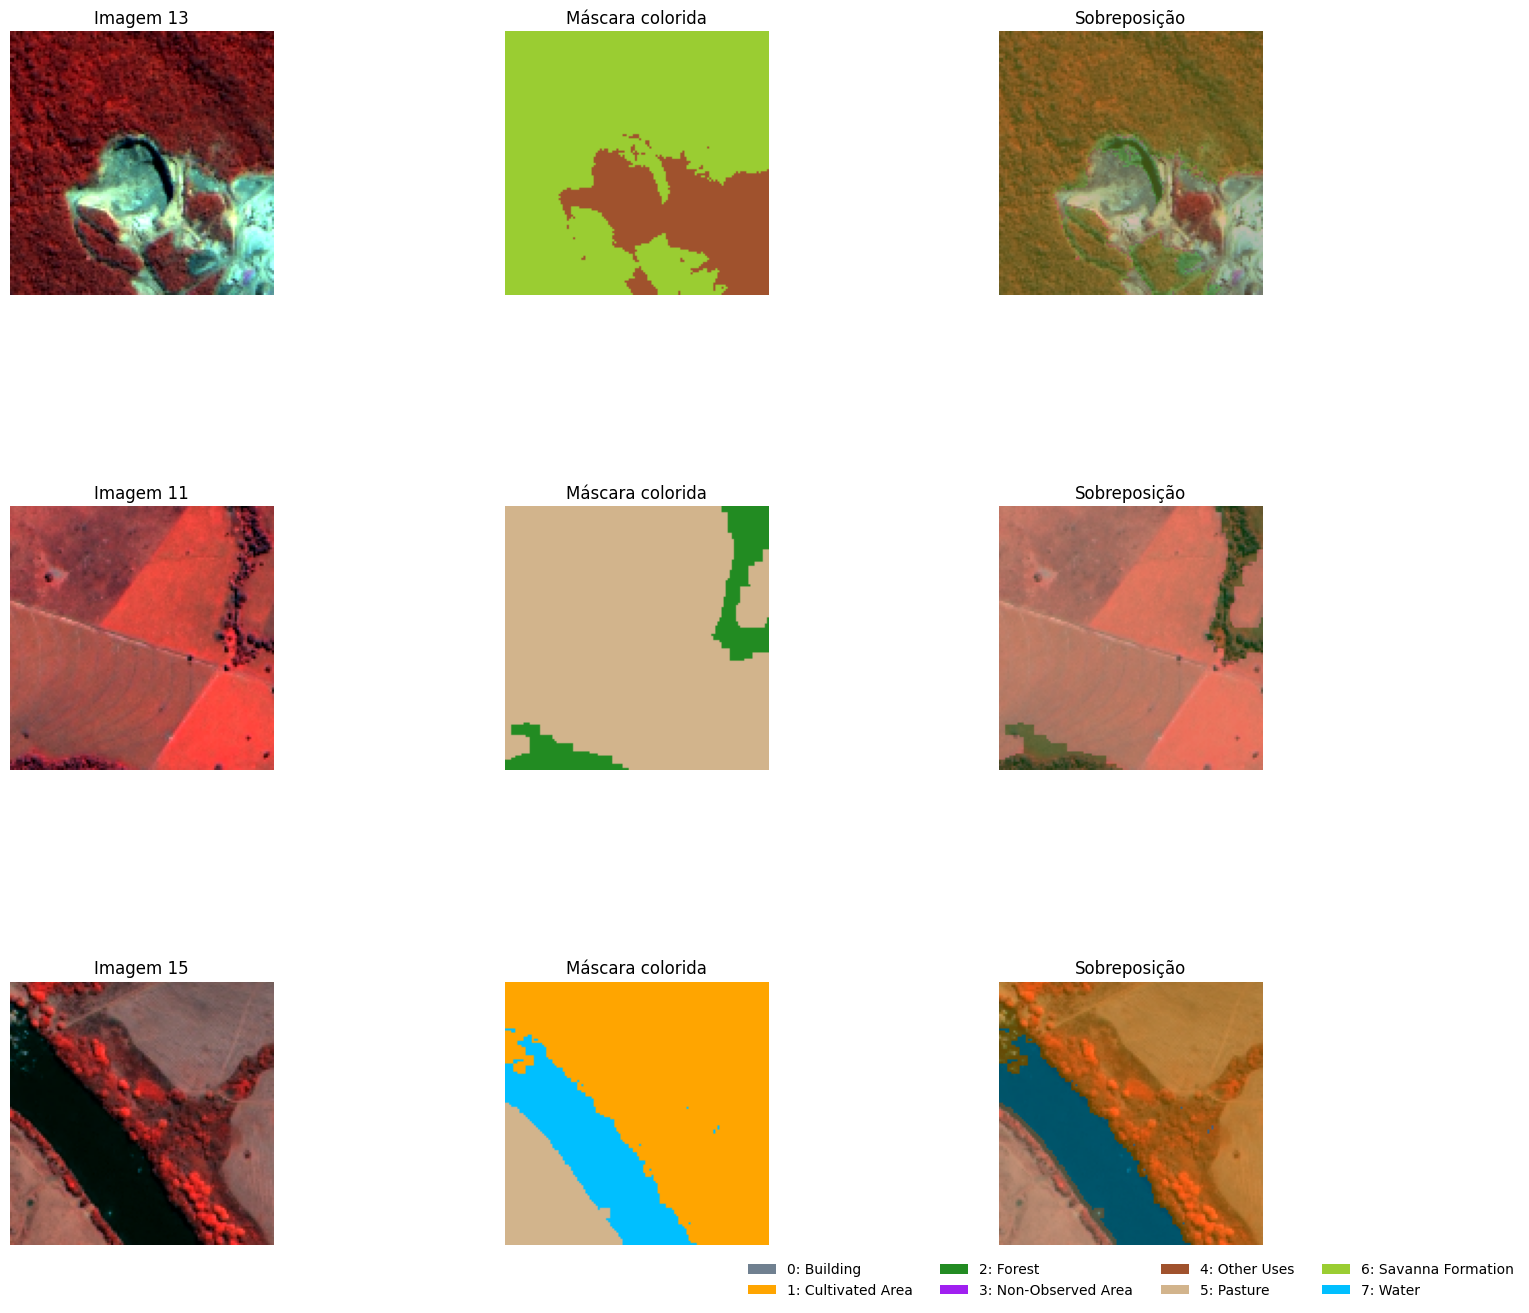

In [ ]:
X_sample, y_sample = train_gen[0]  # primeiro batch
loader.visualize_samples(X_sample, y_sample, n_samples=3)

### 1.2.4 Analisando o dataset

In [10]:
def analyze_dataset(dataset_gen, class_colors=CLASS_COLORS, title="Distribuição do Dataset"):
    """
    Analisa o dataset e plota a distribuição das classes

    Args:
        dataset_gen: Gerador de dados (deve retornar (X, y))
        class_colors: Dicionário com cores para cada classe
        title: Título do gráfico
    """
    class_counts = defaultdict(int)
    total_pixels = 0
    image_shapes = set()
    unique_values = set()

    # Iterar por todos os batches do dataset
    for i in range(len(dataset_gen)):
        _, y_batch = dataset_gen[i]
        y_batch = y_batch.squeeze()  # Remove dimensão extra se existir

        # Coletar estatísticas
        image_shapes.add(y_batch.shape[1:])  # Formato das imagens
        unique_values.update(np.unique(y_batch))  # Valores únicos encontrados

        # Contar pixels por classe
        for class_id in class_colors.keys():
            class_counts[class_id] += np.sum(y_batch == class_id)
            total_pixels += np.sum(y_batch == class_id)

    # Converter contagens para percentuais
    class_percentages = {k: (v / total_pixels * 100) for k, v in class_counts.items()}

    # Plotar distribuição
    plt.figure(figsize=(12, 6))

    # Gráfico de barras
    plt.subplot(1, 2, 1)
    bars = plt.bar(class_percentages.keys(), class_percentages.values(),
                  color=[np.array(class_colors[k])/255.0 for k in class_percentages.keys()])
    plt.title('Distribuição Percentual por Classe')
    plt.xlabel('Classes')
    plt.ylabel('Percentual de Pixels (%)')

    # Adicionar valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    # Gráfico de pizza
    plt.subplot(1, 2, 2)
    patches, texts, autotexts = plt.pie(class_percentages.values(),
                                       labels=class_percentages.keys(),
                                       colors=[np.array(class_colors[k])/255.0 for k in class_percentages.keys()],
                                       autopct='%1.1f%%',
                                       startangle=90)
    plt.title('Distribuição em Pizza')
    plt.axis('equal')  # Assegura que o pie é desenhado como um círculo

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # Imprimir informações adicionais
    print("\nInformações Adicionais:")
    print(f"Total de pixels analisados: {total_pixels}")
    print(f"Formatos de imagem encontrados: {image_shapes}")
    print(f"Valores únicos encontrados: {sorted(unique_values)}")
    print("\nDistribuição por classe (absoluta/percentual):")
    for class_id in sorted(class_colors.keys()):
        print(f"Classe {class_id}: {class_counts[class_id]} pixels ({class_percentages[class_id]:.2f}%)")

    return class_counts, class_percentages

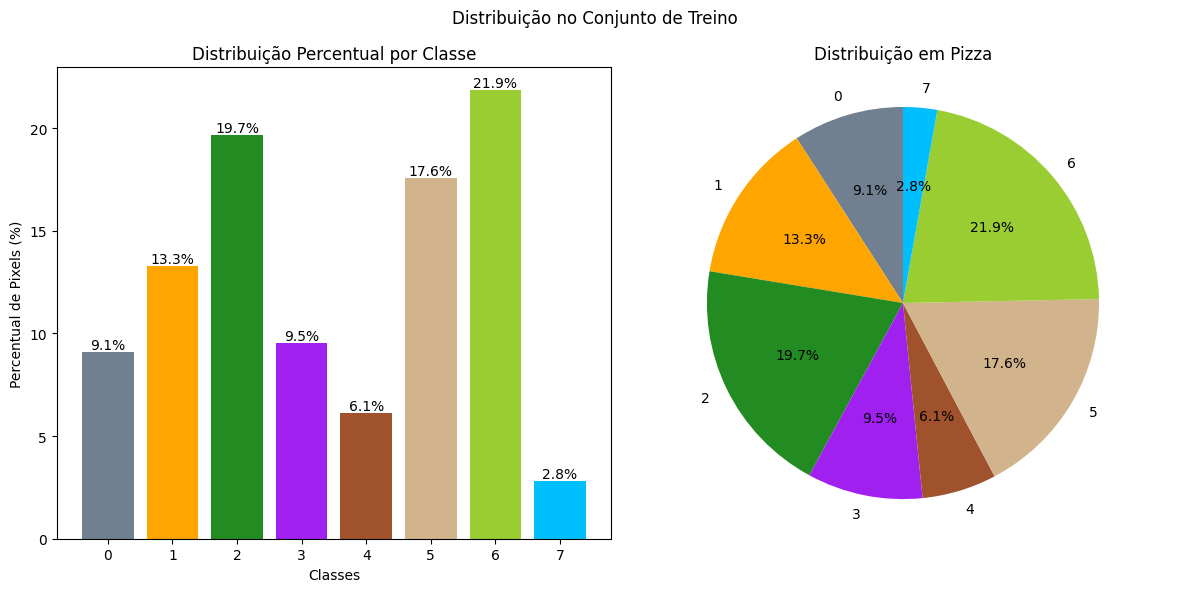


Informações Adicionais:
Total de pixels analisados: 18825216
Formatos de imagem encontrados: {(128, 128)}
Valores únicos encontrados: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)]

Distribuição por classe (absoluta/percentual):
Classe 0: 1716043 pixels (9.12%)
Classe 1: 2501900 pixels (13.29%)
Classe 2: 3702890 pixels (19.67%)
Classe 3: 1792469 pixels (9.52%)
Classe 4: 1156238 pixels (6.14%)
Classe 5: 3310033 pixels (17.58%)
Classe 6: 4116854 pixels (21.87%)
Classe 7: 528789 pixels (2.81%)


In [11]:
# Plota gráficos e imprime informações o dataset
class_counts, class_percentages = analyze_dataset(train_gen, title="Distribuição no Conjunto de Treino")

#### Sobre as classes:

- id: 0; Building: building urban and rural areas;
- id: 1; Cultivated Area: agriculture with one, two or more cycles, perennial and semi-perennial;
- id: 2; Forest: Arboreal formation and riparian forests, galleries, drought, and forestry;
- id: 3; Non-Observed Area: clouds, cloud shadows, fires and fire scars;
- id: 4; Other uses: Mining, rocky outcrops, beaches, and dunes;
- id: 5; Pasture: Grassland formations and herbaceous forage vegetation of cultivated species;
- id: 6; Savanna Formation: Woodland savanna, typical savanna, rupestrian savanna, shrub savanna, and vereda;
- id: 7; Water: River, small lakes, dams, and fish farming ponds.

## 1.2 O Modelo
A arquitetura CNN usada neste caso de estudo é uma adaptação da rede U-Net, antes desenvolvido por Olaf Ronneberger, Philipp Fischer, e Thomas Brox (2015). O modelo recebe imagens de entrada com `128,128,3`, que corresponde às dismensões das imagens. As camadas convolucionais são ativada pela função `relu`, exceto a camada de saída, sendo ela ativada pela função `softmax`. As taxas de ganho e perda são aferidas, respectivamente, por `sparse_categorical_crossentropy` e `accuracy`, otimizados pela função `adam`.

#### 1.2.1 O Treinamento

In [ ]:
# Definindo o modelo
model = custom_unet(...)

# Compilador
model.compile(...)


# Treinamento
history = model.fit(...)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_37']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


72/72 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.1855 - loss: 5.8767 - val_accuracy: 0.2641 - val_loss: 1.6984
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 698ms/step - accuracy: 0.3627 - loss: 1.5832 - val_accuracy: 0.4687 - val_loss: 1.3718
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 704ms/step - accuracy: 0.4853 - loss: 1.4547 - val_accuracy: 0.4578 - val_loss: 1.5242
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 692ms/step - accuracy: 0.4442 - loss: 1.5781 - val_accuracy: 0.5198 - val_loss: 1.3383
Epoch 5/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 686ms/step - accuracy: 0.5104 - loss: 1.3435 - val_accuracy: 0.5604 - val_loss: 1.2639
Epoch 6/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 694ms/step - accuracy: 0.5580 - loss: 1.2333 - val_accuracy: 0.5869 - val_loss: 1.2231
Epoch 7/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 684ms/step - accuracy: 0.5778 - loss: 1.1843 - val_accuracy: 0.5855 - val_loss: 1.1654
Epoch 8/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 691ms/step - accuracy: 0.5951 - loss: 1.1498 - val_accuracy: 0.5911 

**Histórico do treinamento**

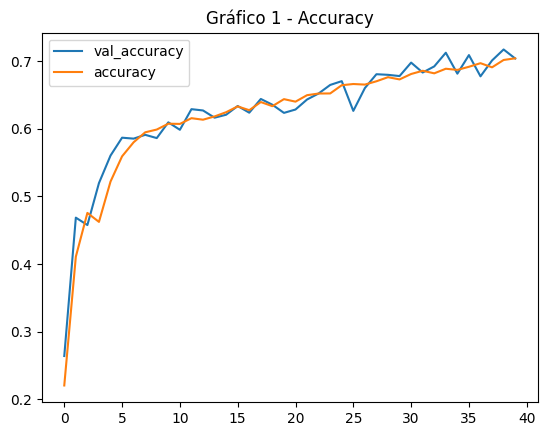

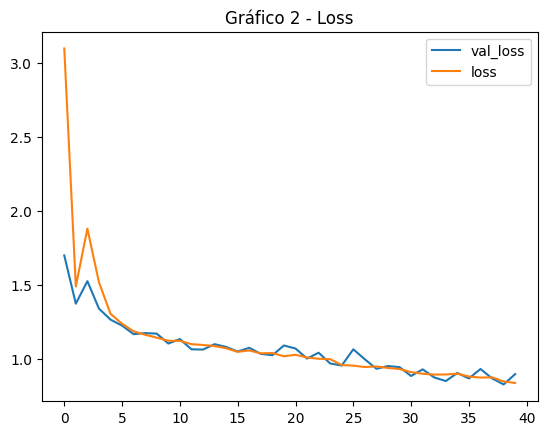

In [ ]:
# Visualizando o resultado do treinamento
losses = pd.DataFrame(model.history.history)[['val_accuracy','accuracy']]
losses.plot()
plt.title("Gráfico 1 - Accuracy")
plt.show()
losses = pd.DataFrame(model.history.history)[['val_loss','loss']]
losses.plot()
plt.title("Gráfico 2 - Loss")
plt.show()

**Salva o modelo treinado**

In [ ]:
from datetime import datetime
import os

# Criar diretório para salvar os modelos se não existir
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

# Gerar nome único para o modelo com extensão .keras
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"cerra_unet_model_{timestamp}.keras"  # Adicionando extensão .keras
model_path = os.path.join(model_dir, model_name)

# Salvar o modelo completo (arquitetura + pesos + otimizador)
model.save(model_path)

# Opção alternativa para salvar no formato .h5
h5_model_name = f"cerra_unet_model_cerradata3_{timestamp}.h5"
h5_model_path = os.path.join(model_dir, h5_model_name)
model.save(h5_model_path)

print(f"Modelo salvo em formato Keras (.keras): {model_path}")
print(f"Modelo salvo em formato HDF5 (.h5): {h5_model_path}")

Modelo salvo em formato Keras (.keras): saved_models/cerra_unet_model_20250518_150036.keras
Modelo salvo em formato HDF5 (.h5): saved_models/cerra_unet_model_cerradata3_20250518_150036.h5


In [20]:
def load_saved_model(model_path):
    """Carrega um modelo salvo"""
    try:
        model = load_model(model_path)
        print(f"Modelo carregado com sucesso de: {model_path}")
        return model
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        return None

#### 1.2.2 Teste e avaliação
O teste e avaliação do modelo consistem em utilizar os métodos `model.predict()` e `model.evaluate()` que, apartir do modelo treinado, faz a previsão da posição de cada classe na imagem 'real' e assim segmenta-a, enquanto que o segundo método compara todas as máscaras desejadas, de suas respectivas imagens, com as imagens segmentadas pelo modelo.

In [26]:
def visualize_test_results(model, test_gen, num_samples=3, batch_index=0):
    """
    Visualiza resultados do teste com máscaras coloridas e métricas

    Args:
        model: Modelo treinado
        test_gen: Gerador de dados de teste
        num_samples: Número de amostras para visualizar
        batch_index: Índice do batch a ser visualizado
    """
    # Obter um batch de dados
    X_batch, y_true_batch = test_gen[batch_index]

    # Fazer previsões
    y_pred_batch = model.predict(X_batch)

    # Converter predições em classes (se for saída multiclasse)
    if y_pred_batch.shape[-1] > 1:
        y_pred_batch = np.argmax(y_pred_batch, axis=-1)
        y_pred_batch = np.expand_dims(y_pred_batch, axis=-1)
    else:
        y_pred_batch = (y_pred_batch > 0.5).astype(np.int32)

    # Configurar figura
    plt.figure(figsize=(18, 5*num_samples))

    for i in range(min(num_samples, len(X_batch))):
        # Obter amostras
        image = X_batch[i]
        true_mask = y_true_batch[i].squeeze()
        pred_mask = y_pred_batch[i].squeeze()

        # Aplicar colormap
        true_mask_rgb = _apply_colormap(true_mask)
        pred_mask_rgb = _apply_colormap(pred_mask)

        # Calcular métricas para esta amostra
        iou_scores = {}
        for class_id in CLASS_COLORS.keys():
            true_class = (true_mask == class_id)
            pred_class = (pred_mask == class_id)

            if np.sum(true_class) > 0 or np.sum(pred_class) > 0:
                intersection = np.logical_and(true_class, pred_class)
                union = np.logical_or(true_class, pred_class)
                iou_scores[class_id] = np.sum(intersection) / (np.sum(union) + 1e-7)

        # Plotar
        # Imagem original
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(image)
        plt.title(f'Imagem {i+1}')
        plt.axis('off')

        # Máscara verdadeira
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(true_mask_rgb)
        plt.title('Máscara Verdadeira')
        plt.axis('off')

        # Máscara prevista
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(pred_mask_rgb)
        plt.title('Máscara Prevista')
        plt.axis('off')

        # Sobreposição
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(image)
        plt.imshow(pred_mask_rgb, alpha=0.4)
        plt.title('Sobreposição (IoU por classe)')

        # Adicionar métricas como texto
        metrics_text = "\n".join([f"Classe {k}: {v:.2f}" for k, v in iou_scores.items()])
        plt.text(0.5, -0.2, metrics_text,
                 ha='center', va='center',
                 transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.8))
        plt.axis('off')

    # Criar legenda
    legend_elements = [
        Patch(facecolor=np.array(CLASS_COLORS[cid])/255.0, label=f"{cid}: {label}")
        for cid, label in zip(
            CLASS_COLORS.keys(),
            [
                "Building", "Cultivated Area", "Forest", "Non-Observed Area",
                "Other Uses", "Pasture", "Savanna Formation", "Water"
            ]
        )
    ]

    plt.figlegend(
        handles=legend_elements,
        loc='lower center',
        ncol=4,
        bbox_to_anchor=(0.5, -0.05),
        title="Classes"
    )

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plota a matriz de confusão de forma visual

    Args:
        conf_matrix: Matriz de confusão (numpy array)
        class_names: Lista com os nomes das classes
    """
    plt.figure(figsize=(10, 8))

    # Normalizar por linha (verdadeiro)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    sns.heatmap(
        conf_matrix_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        vmin=0, vmax=1
    )

    plt.title('Matriz de Confusão Normalizada')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_gen):
    """
    Avalia o modelo no conjunto de teste e retorna métricas agregadas

    Returns:
        dict: Dicionário com métricas de avaliação
    """
    iou_scores = {k: [] for k in CLASS_COLORS.keys()}
    accuracy_scores = []
    all_true = []
    all_pred = []

    for batch_idx in range(len(test_gen)):
        X_batch, y_true_batch = test_gen[batch_idx]
        y_pred_batch = model.predict(X_batch)

        if y_pred_batch.shape[-1] > 1:
            y_pred_batch = np.argmax(y_pred_batch, axis=-1)
        else:
            y_pred_batch = (y_pred_batch > 0.5).astype(np.int32)

        y_true_batch = y_true_batch.squeeze()

        # Armazenar para cálculo agregado
        all_true.extend(y_true_batch.flatten())
        all_pred.extend(y_pred_batch.flatten())

        # Calcular métricas por classe
        for class_id in CLASS_COLORS.keys():
            true_class = (y_true_batch == class_id)
            pred_class = (y_pred_batch == class_id)

            intersection = np.logical_and(true_class, pred_class)
            union = np.logical_or(true_class, pred_class)

            iou = np.sum(intersection) / (np.sum(union) + 1e-7)
            iou_scores[class_id].append(iou)

        # Acurácia geral
        accuracy = np.mean(y_true_batch == y_pred_batch)
        accuracy_scores.append(accuracy)

    # Converter para arrays numpy
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)

    # Calcular F1-score por classe e macro/micro averages
    f1_per_class = f1_score(all_true, all_pred, average=None, labels=list(CLASS_COLORS.keys()))
    f1_scores = {
        'per_class': {class_id: score for class_id, score in zip(CLASS_COLORS.keys(), f1_per_class)},
        'macro': f1_score(all_true, all_pred, average='macro'),
        'micro': f1_score(all_true, all_pred, average='micro')
    }

    # Calcular matriz de confusão
    conf_matrix = confusion_matrix(all_true, all_pred, labels=list(CLASS_COLORS.keys()))

    # Plotar matriz de confusão
    class_names = [
        "Building", "Cultivated Area", "Forest", "Non-Observed Area",
        "Other Uses", "Pasture", "Savanna Formation", "Water"
    ]
    plot_confusion_matrix(conf_matrix, class_names)

    # Calcular médias
    results = {
        'mean_accuracy': np.mean(accuracy_scores),
        'class_iou': {k: np.mean(v) for k, v in iou_scores.items()},
        'mean_iou': np.mean([np.mean(v) for v in iou_scores.values()]),
        'f1_scores': f1_scores,
        'confusion_matrix': conf_matrix.tolist(),  # Converter para lista para serialização
        'confusion_matrix_classes': list(CLASS_COLORS.keys())  # Ordem das classes na matriz
    }

    return results

##### Carrega o modelo treinado

In [12]:
# Download o modelo treinado
path = kagglehub.model_download("cerranet/u-net-on-cerradata-3/keras/default")
print("Path to model files:", path)


  0%|          | 0.00/1.39G [00:00<?, ?B/s]



  0%|          | 0.00/1.39G [00:00<?, ?B/s]
  0%|          | 1.00M/1.39G [00:00<07:57, 3.11MB/s]
  0%|          | 4.00M/1.39G [00:00<02:16, 10.9MB/s]

  0%|          | 1.00M/1.39G [00:00<07:49, 3.17MB/s]
  1%|          | 11.0M/1.39G [00:00<00:52, 28.3MB/s]

  0%|          | 4.00M/1.39G [00:00<02:14, 11.1MB/s]
  1%|▏         | 18.0M/1.39G [00:00<00:36, 40.4MB/s]

  1%|          | 11.0M/1.39G [00:00<00:51, 28.6MB/s]
  2%|▏         | 24.0M/1.39G [00:00<00:31, 45.8MB/s]

  1%|          | 16.0M/1.39G [00:00<00:42, 35.0MB/s]
  2%|▏         | 31.0M/1.39G [00:00<00:27, 53.2MB/s]

  2%|▏         | 24.0M/1.39G [00:00<00:32, 45.0MB/s]
  3%|▎         | 37.0M/1.39G [00:00<00:26, 55.1MB/s]

  2%|▏         | 31.0M/1.39G [00:00<00:29, 50.0MB/s]
  3%|▎         | 44.0M/1.39G [00:01<00:25, 57.4MB/s]

  3%|▎         | 38.0M/1.39G [00:01<00:26, 54.0MB/s]
  4%|▎         | 51.0M/1.39G [00:01<00:23, 61.4MB/s]

  3%|▎         | 45.0M/1.39G [00:01<00:25, 57.6MB/s]
  4%|▍         | 58.0M/1.39G [00:01<00:23, 62

Path to model files: /root/.cache/kagglehub/models/cerranet/u-net-on-cerradata-3/keras/default/1


In [15]:
# Move a pasta para o diretório principal
!mv ...

In [ ]:
model_path = '...'
# Carregar o modelo
loaded_model = load_saved_model(model_path)


#####  **Resultados Qualitativos**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


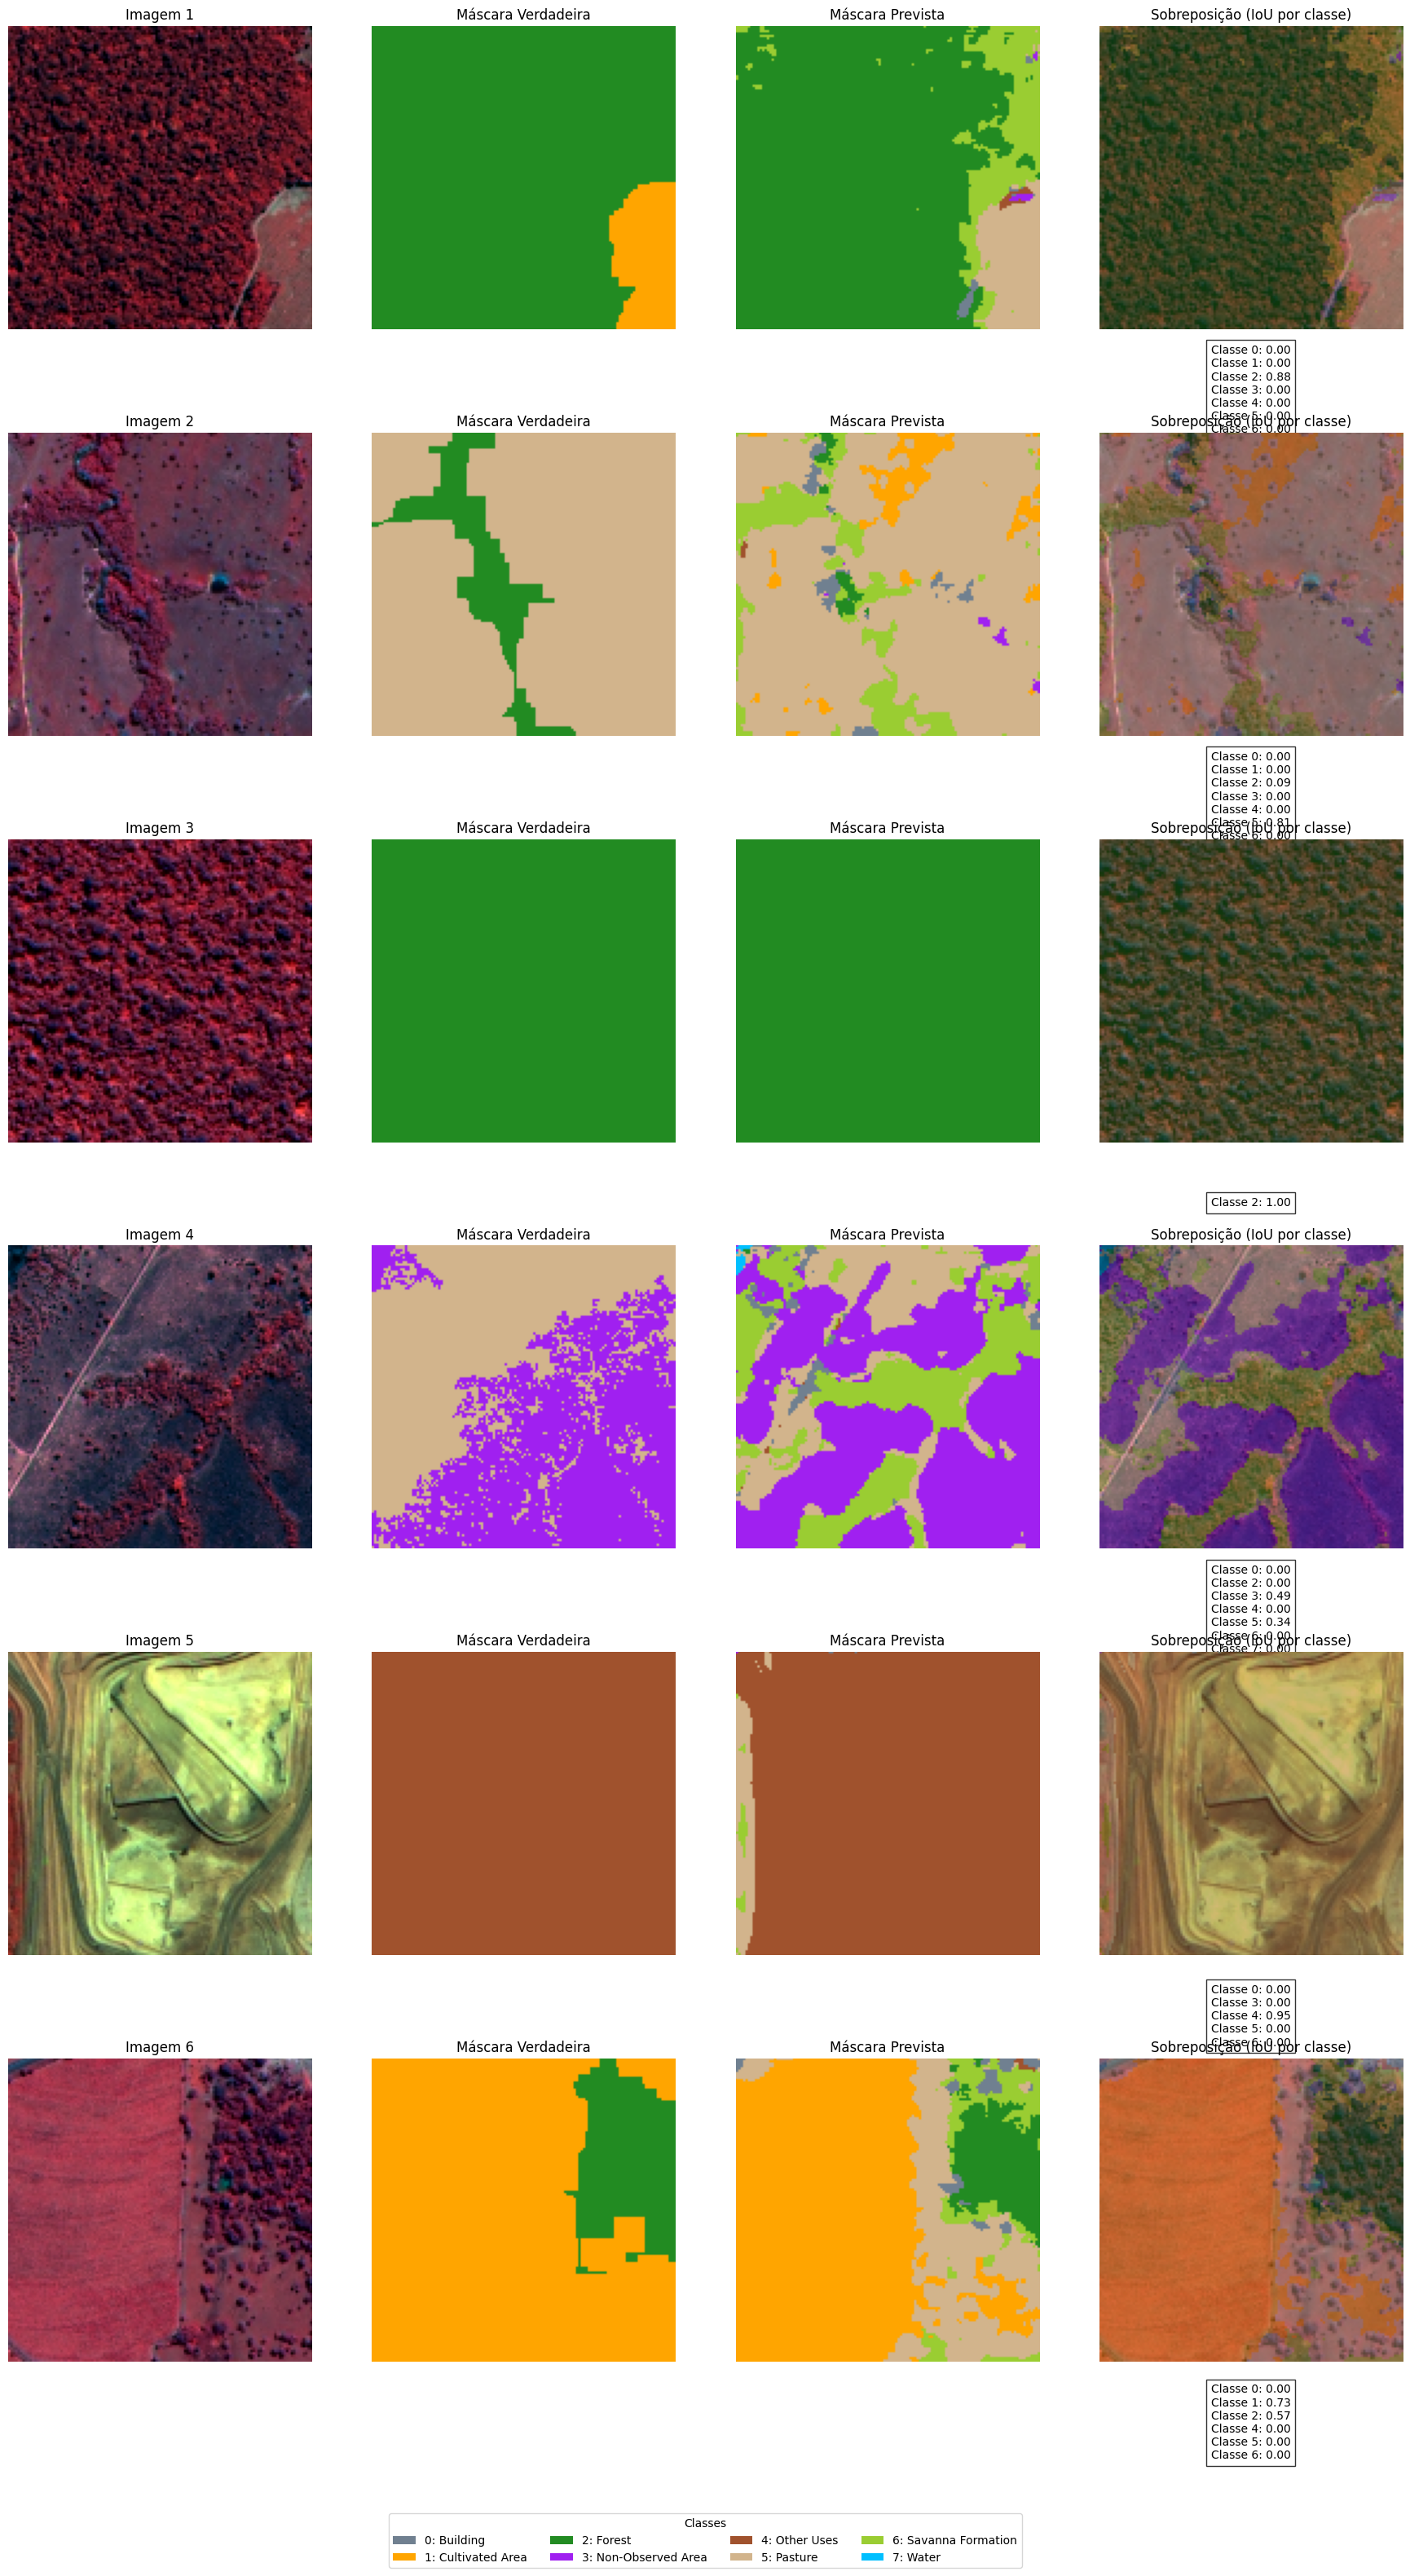

In [30]:
# 1. Visualizar resultados
visualize_test_results(...)

#####  **Resultados Quantitativos**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


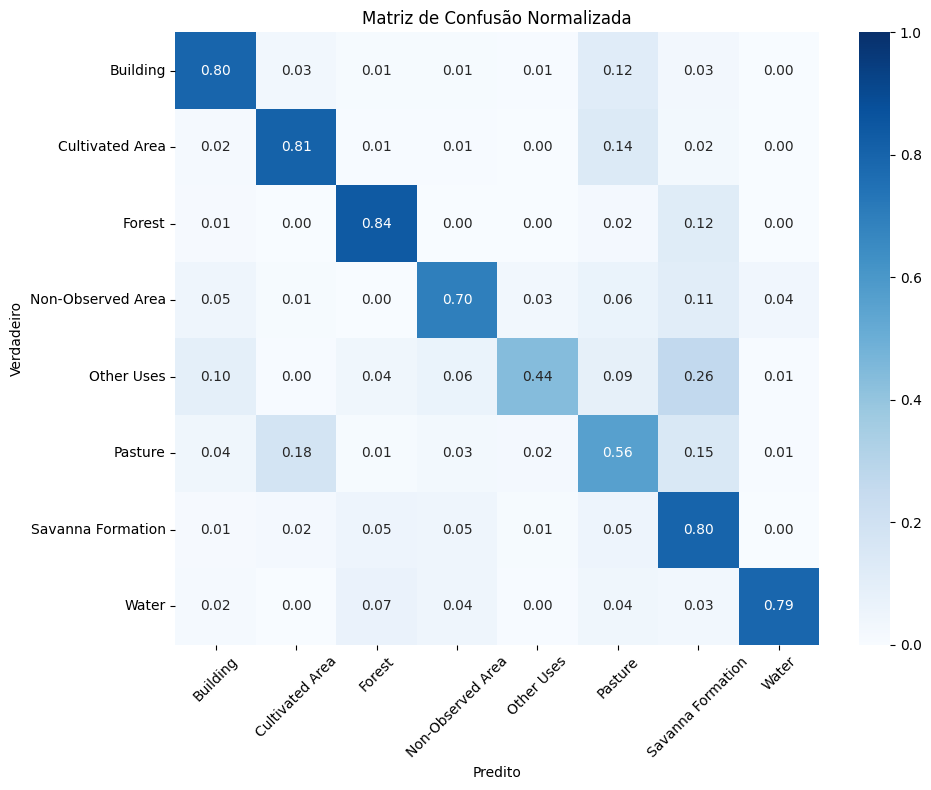


Métricas de avaliação:
Acurácia média: 0.7342

F1-scores:
  Macro F1: 0.7197

F1 por classe:
  Classe 0: 0.7629
  Classe 1: 0.7786
  Classe 2: 0.8610
  Classe 3: 0.7435
  Classe 4: 0.5390
  Classe 5: 0.5834
  Classe 6: 0.7356
  Classe 7: 0.7538

IoU médio: 0.5106

IoU por classe:
  Classe 0: 0.5409
  Classe 1: 0.5678
  Classe 2: 0.6465
  Classe 3: 0.5384
  Classe 4: 0.3314
  Classe 5: 0.3973
  Classe 6: 0.5570
  Classe 7: 0.5058


In [29]:
metrics = evaluate_model(...)

print("\nMétricas de avaliação:")
print(f"Acurácia média: {metrics['mean_accuracy']:.4f}")
print("\nF1-scores:")
print(f"  Macro F1: {metrics['f1_scores']['macro']:.4f}")
print("\nF1 por classe:")
for class_id, f1 in metrics['f1_scores']['per_class'].items():
    print(f"  Classe {class_id}: {f1:.4f}")

print(f"\nIoU médio: {metrics['mean_iou']:.4f}")
print("\nIoU por classe:")
for class_id, iou in metrics['class_iou'].items():
    print(f"  Classe {class_id}: {iou:.4f}")

# Referências
[Żak, K., 2019] Unet. https://github.com/karolzak/keras-unet <br>
[Sciit-image] General  purpose imagens. https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html#sphx-glr-auto-examples-data-plot-general-py